<a href="https://colab.research.google.com/github/sw-programmer/Coursework1/blob/sangwoo/CW1_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Coursework 1**

1.   ### **Computationally Efficient Eigenfaces**
2.   ### **Incremental PCA**
3.   ### **PCA-LDA for Face Recognition**
4.   ### **K-means codebook**
5.   ### **RF classifier**


**by 20190223	Soohyun Ryu,	20190247	Sangwoo Park**






**1. Setting!**

In [2]:
# import os
# import time
# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import datetime
# import math
# import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mat_file = io.loadmat("/content/drive/MyDrive/CV_ML/CW1/face.mat")
mat_X = mat_file['X']
mat_Y = mat_file['l'][0]

print(mat_file.keys()) 
print(mat_X.shape)                         # 총 52명. 각 10장의 사진. 

dict_keys(['__header__', '__version__', '__globals__', 'X', 'l'])
(2576, 520)


       0    1    2    3    4    5  ...  2571  2572  2573  2574  2575  label
0    106  103  103  104  101  104  ...    41    41    37    36    41      1
1    130  129  130  129  133  135  ...    43    41    40    36    35      1
2    191  185  174  153  137  114  ...    28    25    22    19    17      1
3    161  156  141  132  133  108  ...    57    58    58    59    60      1
4    161  162  160  151  107  101  ...    55    52    50    47    46      1
..   ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   ...   ...    ...
515  181  170  163  160  156  148  ...    93    75    61    50    45     52
516   60   68   71   77   76   78  ...    86    86    41    48    65     52
517   70   62   83   75   65   71  ...    83    83    87    89    94     52
518  183  250  163   61   74   51  ...   123    86   102    95   106     52
519   77   72   68   64   62   55  ...    73   142    93   103   110     52

[520 rows x 2577 columns]
(416, 2576) (104, 2576) (416,) (104,)


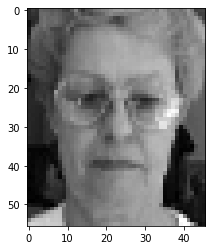

In [67]:
df = pd.DataFrame(data=mat_X).transpose()
df['label'] = mat_Y                         # row -> data, col -> feature
print(df)

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values # column 'Target'

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=35) #sklearn lib
# test/train ratio = 0.2
# random_state -> before dividing, seed for shuffling
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

plt.imshow(np.reshape(X_train[0,:],(46,56)).T, cmap = 'gist_gray') # 그냥...어떻게 생겼나 궁금해서...

## **1. Computationally Efficient Eignefaces**



In [68]:
# 평균 얼굴 계산 함수 
def AvgCompute(X): 
  Xbar = np.mean(X, axis=0)  
  matrix_A = X - Xbar 
  return matrix_A, Xbar

# 고유값, 고유벡터 계산 함수
def eig(S): 
  eig_vals, eig_vecs = np.linalg.eig(S) 
  sort_indices = np.argsort(eig_vals)[::-1] # 내림차순 정렬 
  return eig_vals[sort_indices], eig_vecs[:, sort_indices]

# Reconstruction에 쓰일 함수
def reconstruct(X, PC): 
  return (X @ PC) @ PC.T 

# PCA 과정
def PCA(X, num_components): # X == train set, num_components == 선택할 eigen vectoe 개수
  N, D = X.shape 
  matrix_A, X_bar = AvgCompute(X) 
  S = (matrix_A.T @ matrix_A) / N 
  eig_vals, eig_vecs = eig(S) 
  
  principal_vals, principal_components = np.real(eig_vals[:num_components]), np.real(eig_vecs[:,:num_components]) 
  
  reconst_X = reconstruct(matrix_A, principal_components) + X_bar 
  
  return reconst_X, X_bar, principal_vals, principal_components

(2576,)
(416, 2576)


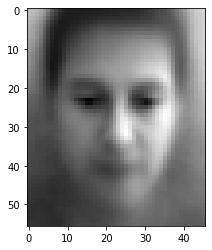

In [126]:
A, X_bar = AvgCompute(X_train) 
print(X_bar.shape)
print(A.shape)

plt.imshow(np.reshape(X_bar,(46,56)).T, cmap = 'gist_gray') # 평균 얼굴 출력

In [146]:
# 1. S=(1/N)AAT 방식
row, col = X_train.shape
S = (A.T @ A) / row
eig_vals_high, eig_vecs_high = eig(S) # High dimnesional
eig_vals_high = np.real(eig_vals_high)
eig_vecs_high = np.real(eig_vecs_high)

print(eig_vals_high.shape)
print(eig_vecs_high.shape)

(2576,)
(2576, 2576)


* Pros : 보다 정확
* Cons : Ineffieciency of Computation

In [147]:
# 2.  (1/N)ATA 방식
S = (A @ A.T) / row
eig_vals_low, eig_vecs_low = eig(S) # Low dimnesional
eig_vals_low = np.real(eig_vals_low)
eig_vecs_low = np.real(eig_vecs_low)

print(eig_vals_low.shape)
print(eig_vecs_low.shape)

(416,)
(416, 416)


* Pros : Effieciency of Computation
* Cons : 선택할 수 있는 EigenVector 수가 적다(?) -> Less accurate



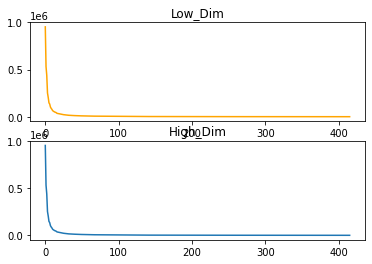

In [159]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.title('Low_Dim')
ax1.plot(range(0,416), eig_vals_low, color='orange')	
ax2 = fig.add_subplot(212)
plt.title('High_Dim')
ax2.plot(range(0,416), eig_vals_high[:416])	 # 두 eigenvalue 그래프가 동일함

print()